### What is this notebook for? ###

The main purpose of this notebook is building dataset for training Liquidity's probability model.
Here we will enrich listings attributes with replies(within 7 days after creation) and javascript events(within 7 days after creation). In addition we will fix the issue  with 0 images for inactive listings.

JS events:

* 'reply_phone_show',
* 'reply_phone_call',
* 'reply_phone_sms',
* 'reply_phone_cancel',
* 'reply_message_sent',
* 'reply_message_click',
* 'reply_chat_sent'

**Prerequisities:**  

* csv file with listings attributes "imovirtual_Jun_Dec.csv". Can be obtained with sql code in the file `sql_queries/imovirtual.sql`, section 1.
* parsed attributes "ads_with_featuresImo.csv". Can be obtained with `ParamsImovirtual.ipynb`
* replies "imovirtual_replies_Jun_Dec.csv". Can be obtained with sql code in the file `sql_queries/imovirtual.sql`, section 2.
* js events within 7 days "imovirtual_js_events_Jun_Dec.csv". Can be obtained with sql code in the file `sql_queries/imovirtual.sql`, section 3.
* listigs images amount "imo_images_Jun_Dec.csv". Can be obtained with sql code in the file`sql_queries/imovirtual.sql`, section 4.
* [optional] views within 7 days imovirtual_views_Jun_Dec.csv. Can be obtained with sql code in the file `sql_queries/imovirtual.sql`, section 5.

**Output:**
"ml_dataset_imovirtual.tsv", separated with "\t"

In [7]:
import pandas as pd
import numpy as np
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ads = pd.read_csv('data/Imovirtual/imovirtual_Jun_Dec.csv', header=None)

/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
ads.head()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,6832896,1,101,5,NaN,1053706,34925,NaN,2017-06-02 20:08:08.000000,2016-11-01 00:00:00.000000,...,0,75.0,99000,1320,NaN,0,25,-8.691601,40.557465,1
1,6832910,1,401,5,NaN,1053697,34925,NaN,2017-06-02 20:09:05.000000,2016-11-01 00:00:00.000000,...,0,0.0,225000,0,NaN,0,25,-8.628854,40.599466,1
2,6832982,1,101,10,NaN,1058821,34925,NaN,2017-06-02 20:09:17.000000,2016-11-01 00:00:00.000000,...,0,75.0,250000,3333,NaN,0,25,-8.751462,40.613227,1
3,6832984,1,101,5,NaN,1053713,34925,NaN,2017-06-02 20:09:17.000000,2016-11-01 00:00:00.000000,...,0,153.0,152000,993,NaN,2,25,-8.622305,40.660020,1
4,8003800,11,302,153,NaN,11540490,401552,NaN,2017-06-02 05:41:44.000000,2017-06-02 10:59:20.000000,...,0,0.0,350,0,NaN,32,100,NaN,NaN,1


In [4]:
ads.columns = ["ad_id", "region_id", "category_id", "subregion_id", "district_id", "city_id", "user_id", 
               "last_update_date", "created_at_first", "valid_to", "status", "title", "description",
               "params", "map_address", "private_business", 
"images_counter", "paidads_id_index", "paidads_id_payment", "paidads_valid_to", "was_paid_for_post",
"is_paid_for_post", "export_olx_to", "brand_program_id", "user_quality_score", "updated_at",
"street_name", "street_id", "panorama", "mysql_search_rooms_num", "mysql_search_m",
"mysql_search_price", "mysql_search_price_per_m", "movie", "ad_quality_score", "user_quality_score2",
"map_lon", "map_lat", "net_ad_counted"]

In [5]:
ads['ad_id'].nunique()

312639

In [8]:
# Convert to datetime
ads['created_at_dt'] = ads.apply(
    lambda row: datetime.datetime.strptime(row['created_at_first'], '%Y-%m-%d %H:%M:%S.%f').date()
    if len(str(row['created_at_first'])) > 5 else 'false', axis=1) 

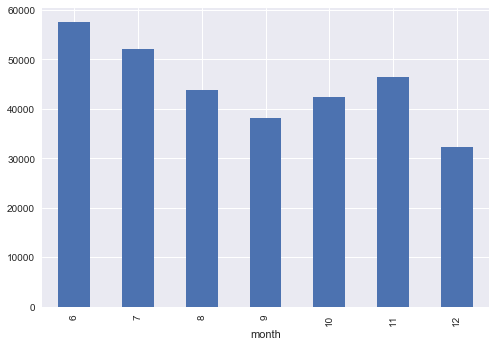

In [9]:
ads['month'] = ads['created_at_dt'].apply(lambda x: x.month)
ads.groupby(['month'])['ad_id'].nunique().plot(kind="bar")

In [10]:
ads['created_at_dt'].max()

datetime.date(2017, 12, 31)

Add parsed parameters

In [11]:
features = pd.read_csv("ads_with_featuresImo.csv")

/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (9,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
features = features.fillna('no')

In [13]:
features.head()

,ad_id,area_gross,bathrooms_num,condition,construction_license,construction_year,divisions_num,energy_certificate,exchange,floors,...,price,price[currency],price_per_m,purpose,register_number,rooms_num,slope,storage_space,terrain_area,type
0,6816590,no,1,usado,no,1980,no,no,no,no,...,85000.0,EUR,653.85,no,no,2,no,no,no,no
1,6816592,no,2,usado,no,1996,no,d,0,no,...,123000.0,EUR,1268.04,no,no,2,no,no,no,no
2,6816594,no,1,renovado,no,1965,no,d,no,no,...,999.0,EUR,39.96,no,no,zero,no,no,no,no
3,6816596,no,no,usado,no,no,no,b,no,no,...,190000.0,EUR,1328.67,no,no,3,no,no,no,no
4,6816598,no,no,usado,no,no,no,no,no,no,...,3800.0,EUR,3.02,no,no,no,no,no,no,no


In [14]:
ads = ads.merge(features, how="left", on="ad_id")

In [15]:
ads['ad_id'].nunique()

312639

In [16]:
ads.shape

(312639, 67)

**  Add replies in 7 days **

In [18]:
answers = pd.read_csv('data/Imovirtual/imovirtual_replies_Jun_Dec.csv', header=None)

In [19]:
answers.columns = ['ad_id', 'ad_created', 'reply_id', 'reply_parent_id', 'reply_sender_id', 'reply_posted_at']

In [20]:
answers.head()

,ad_id,ad_created,reply_id,reply_parent_id,reply_sender_id,reply_posted_at
0,6817896,2017-06-01 10:05:28.000000,18712134,0,1079435,2017-06-01 11:10:37.000000
1,6816848,2017-06-01 05:13:18.000000,18712324,0,1082500,2017-06-01 11:44:44.000000
2,6816848,2017-06-01 05:13:18.000000,18714570,0,1007722,2017-06-01 17:11:49.000000
3,6816754,2017-06-01 04:20:04.000000,18715142,0,85284,2017-06-01 18:41:07.000000
4,6819704,2017-06-01 16:25:20.000000,18717050,0,351872,2017-06-01 22:37:34.000000


In [21]:
answers.shape

(1313909, 6)

In [22]:
answers['replied_at_dt'] =  answers.apply(
    lambda row: datetime.datetime.strptime(row['reply_posted_at'], '%Y-%m-%d %H:%M:%S.%f').date()
    if pd.notnull(row['reply_posted_at']) else 'false', axis=1) 

In [23]:
answers['ad_created'] =  answers.apply(
    lambda row: datetime.datetime.strptime(row['ad_created'], '%Y-%m-%d %H:%M:%S.%f').date()
    if pd.notnull(row['ad_created']) else 'false', axis=1) 

In [24]:
answers.head()

,ad_id,ad_created,reply_id,reply_parent_id,reply_sender_id,reply_posted_at,replied_at_dt
0,6817896,2017-06-01,18712134,0,1079435,2017-06-01 11:10:37.000000,2017-06-01
1,6816848,2017-06-01,18712324,0,1082500,2017-06-01 11:44:44.000000,2017-06-01
2,6816848,2017-06-01,18714570,0,1007722,2017-06-01 17:11:49.000000,2017-06-01
3,6816754,2017-06-01,18715142,0,85284,2017-06-01 18:41:07.000000,2017-06-01
4,6819704,2017-06-01,18717050,0,351872,2017-06-01 22:37:34.000000,2017-06-01


**Count difference in days between creation date and reply date**

In [25]:
answers['replied_days_diff'] = answers.apply(lambda row: (row['replied_at_dt'] - row['ad_created']).days
                     if pd.notnull(row['replied_at_dt']) else None, axis=1)

In [27]:
answers[answers['ad_id'] == 6816848]

,ad_id,ad_created,reply_id,reply_parent_id,reply_sender_id,reply_posted_at,replied_at_dt,replied_days_diff
1,6816848,2017-06-01,18712324,0,1082500,2017-06-01 11:44:44.000000,2017-06-01,0
2,6816848,2017-06-01,18714570,0,1007722,2017-06-01 17:11:49.000000,2017-06-01,0
5,6816848,2017-06-01,18717332,0,1046378,2017-06-01 23:11:06.000000,2017-06-01,0
6,6816848,2017-06-01,18719158,0,1024988,2017-06-02 10:18:01.000000,2017-06-02,1
19,6816848,2017-06-01,118714800,0,1059552,2017-06-01 17:46:25.000000,2017-06-01,0
23,6816848,2017-06-01,118719158,0,1024988,2017-06-02 10:18:01.000000,2017-06-02,1
1601,6816848,2017-06-01,18716550,0,1082937,2017-06-01 21:45:29.000000,2017-06-01,0
1604,6816848,2017-06-01,18716838,0,1082972,2017-06-01 22:13:58.000000,2017-06-01,0
3181,6816848,2017-06-01,18714990,0,1025041,2017-06-01 18:15:30.000000,2017-06-01,0
3189,6816848,2017-06-01,18718750,0,29789,2017-06-02 09:04:50.000000,2017-06-02,1


Answers can be in thread. The first message in the thread have reply_parent_id = 0. We intrested only in that type of replies.

In [28]:
answers = answers[answers['reply_parent_id'] == 0]

We interested in 7 days window:

In [32]:
answers = answers[(answers['replied_days_diff'] < 7) & (answers['replied_days_diff'] >= 0)]

In [34]:
answers[answers['ad_id'] == 6816848].head()

,ad_id,ad_created,reply_id,reply_parent_id,reply_sender_id,reply_posted_at,replied_at_dt,replied_days_diff
1,6816848,2017-06-01,18712324,0,1082500,2017-06-01 11:44:44.000000,2017-06-01,0
2,6816848,2017-06-01,18714570,0,1007722,2017-06-01 17:11:49.000000,2017-06-01,0
5,6816848,2017-06-01,18717332,0,1046378,2017-06-01 23:11:06.000000,2017-06-01,0
6,6816848,2017-06-01,18719158,0,1024988,2017-06-02 10:18:01.000000,2017-06-02,1
19,6816848,2017-06-01,118714800,0,1059552,2017-06-01 17:46:25.000000,2017-06-01,0


In [36]:
answers.shape

(335841, 8)

**Count senders/unique senders amount within 7 days **

In [37]:
liquidity_leads = answers.groupby('ad_id')['reply_sender_id'].nunique()
all_leads = answers.groupby('ad_id')['reply_sender_id'].count()
replies = pd.concat([liquidity_leads, all_leads], axis=1)

In [38]:
replies.head()

,reply_sender_id,reply_sender_id
ad_id,,
6816594,16,32
6816618,2,4
6816620,1,2
6816626,1,2
6816640,1,2


In [39]:
replies['ad_id'] = replies.index

Sanity checks:

In [40]:
replies[replies['ad_id'] == 8752690]

,reply_sender_id,reply_sender_id,ad_id
ad_id,,,
8752690,1,2,8752690


In [41]:
replies.columns = ['unique_replies', 'total_replies', 'ad_id']

In [42]:
replies.head()

,unique_replies,total_replies,ad_id
ad_id,,,
6816594,16,32,6816594
6816618,2,4,6816618
6816620,1,2,6816620
6816626,1,2,6816626
6816640,1,2,6816640


In [43]:
replies[replies['ad_id'] == 8752690]

,unique_replies,total_replies,ad_id
ad_id,,,
8752690,1,2,8752690


#### Prepare js events

In [44]:
js_events = pd.read_csv("data/Imovirtual/imovirtual_js_events_Jun_Dec.csv", header=None)

In [45]:
js_events.head()

,0,1,2
0,8984980,1,3
1,8400259,1,2
2,8550175,37,65
3,8716951,7,13
4,9012649,73,137


In [46]:
js_events.columns = ['ad_id', 'unique_js_events', 'total_events']

In [47]:
js_events.shape

(88366, 3)

**Combine together replies and js events**

In [49]:
replies.head()

,unique_replies,total_replies,ad_id
ad_id,,,
6816594,16,32,6816594
6816618,2,4,6816618
6816620,1,2,6816620
6816626,1,2,6816626
6816640,1,2,6816640


In [50]:
js_events.head()

,ad_id,unique_js_events,total_events
0,8984980,1,3
1,8400259,1,2
2,8550175,37,65
3,8716951,7,13
4,9012649,73,137


In [51]:
ads.head()

,ad_id,region_id,category_id,subregion_id,district_id,city_id,user_id,last_update_date,created_at_first,valid_to,...,price,price[currency],price_per_m,purpose,register_number,rooms_num,slope,storage_space,terrain_area,type
0,6832896,1,101,5,NaN,1053706,34925,NaN,2017-06-02 20:08:08.000000,2016-11-01 00:00:00.000000,...,99000.0,EUR,1320,no,no,2,no,no,no,no
1,6832910,1,401,5,NaN,1053697,34925,NaN,2017-06-02 20:09:05.000000,2016-11-01 00:00:00.000000,...,225000.0,EUR,78.13,no,no,no,no,no,no,no
2,6832982,1,101,10,NaN,1058821,34925,NaN,2017-06-02 20:09:17.000000,2016-11-01 00:00:00.000000,...,250000.0,EUR,3333.33,no,no,2,no,no,no,no
3,6832984,1,101,5,NaN,1053713,34925,NaN,2017-06-02 20:09:17.000000,2016-11-01 00:00:00.000000,...,152000.0,EUR,993.46,no,no,3,no,no,no,no
4,8003800,11,302,153,NaN,11540490,401552,NaN,2017-06-02 05:41:44.000000,2017-06-02 10:59:20.000000,...,350.0,EUR,4.38,no,no,no,no,no,no,no


In [52]:
ads = ads.merge(replies, how='left', on='ad_id')

In [53]:
ads = ads.merge(js_events, how='left', on='ad_id')

In [54]:
ads[['unique_replies', 'total_replies', 'unique_js_events', 'total_events']] = ads[['unique_replies', 'total_replies','unique_js_events', 'total_events']].fillna(0)

In [55]:
ads['unique_senders'] = ads['unique_replies'] + ads['unique_js_events']

In [56]:
ads['total_leads'] = ads['total_replies'] + ads['total_events']

In [58]:
ads.head()

,ad_id,region_id,category_id,subregion_id,district_id,city_id,user_id,last_update_date,created_at_first,valid_to,...,slope,storage_space,terrain_area,type,unique_replies,total_replies,unique_js_events,total_events,unique_senders,total_leads
0,6832896,1,101,5,NaN,1053706,34925,NaN,2017-06-02 20:08:08.000000,2016-11-01 00:00:00.000000,...,no,no,no,no,0.0,0.0,0.0,0.0,0.0,0.0
1,6832910,1,401,5,NaN,1053697,34925,NaN,2017-06-02 20:09:05.000000,2016-11-01 00:00:00.000000,...,no,no,no,no,0.0,0.0,0.0,0.0,0.0,0.0
2,6832982,1,101,10,NaN,1058821,34925,NaN,2017-06-02 20:09:17.000000,2016-11-01 00:00:00.000000,...,no,no,no,no,0.0,0.0,0.0,0.0,0.0,0.0
3,6832984,1,101,5,NaN,1053713,34925,NaN,2017-06-02 20:09:17.000000,2016-11-01 00:00:00.000000,...,no,no,no,no,0.0,0.0,0.0,0.0,0.0,0.0
4,8003800,11,302,153,NaN,11540490,401552,NaN,2017-06-02 05:41:44.000000,2017-06-02 10:59:20.000000,...,no,no,no,no,0.0,0.0,0.0,0.0,0.0,0.0


**Categories list**

* 101 - apartments to buy
* 102 - apartments for rent
* 103 - apartments for vacations
* 201 - houses to buy
* 202 - houses for rent
* 203 - houses for vacations
* 302 - rooms for rent
* 401 - land to buy
* 402 - land for rent
* 501 - stores to buy
* 502 - stors for rent
* 601 - warehouses to buy
* 602 - warehosues for rent
* 701 - garages to buy
* 702 - garages for rent
* 801 - offices to buy
* 802 - offices for rent
* 901 - buildings to buy
* 902 - building for rent
* 1101 - farms and estates to buy
* 1102 - farms and estates for rent
* 1201 - goodwill to buy

**Category distribution**

In [60]:
ads['category_id'].value_counts()

101     138246
201      70564
401      25702
102      23732
501      11851
901       7038
302       5918
502       5049
1101      4368
601       3869
202       3393
802       2788
801       2533
701       1789
602       1769
1201      1536
103       1000
203        716
702        454
402        154
902        105
1102        65
Name: category_id, dtype: int64

#### Liquidity definition ####

**Liquidity** - binary metric. Equal to 1 if listings obtained 3 or more contacts from unique persons within 7 days after creation. Let's calculate liquidity for Imovirtual:

In [64]:
sum(ads['unique_senders']  >= 3)/len(ads)

0.12744731143587332

**Transform image number to integer**

In [65]:
import numpy as np
import pandas as pd
np.binary_repr(int(1.638300e+04))
print(np.binary_repr(int(1.638300e+04)))
print(len(np.binary_repr(int(1.638300e+04))))

11111111111111
14


In [66]:
def get_number_of_images(coded_number):
    if pd.isnull(coded_number):
        return 0
    binary_repr = np.binary_repr(int(coded_number))
    binary_repr  = binary_repr.replace('0', '')
    return len(binary_repr)

In [67]:
get_number_of_images(12)

2

In [68]:
test = get_number_of_images(1.638300e+04)


In [69]:
ads['n_images'] = ads['images_counter'].apply(lambda x: get_number_of_images(x))

In [71]:
ads['n_images'].value_counts(normalize=True).head()

0     0.167532
12    0.056484
5     0.050115
9     0.045490
10    0.045388
Name: n_images, dtype: float64

In [74]:
ads[ads['n_images']  == 0].status.value_counts()

removed_by_user         50656
outdated                  723
outdated_by_package       449
active                    182
disabled                  162
removed_by_moderator      132
moderated                  63
unpaid                     10
Name: status, dtype: int64

16.75% of all listings have zero images. Mostly they have status `removed_by_user`. To obtain the original amount of images we use "imo_images_Jun_Dec.csv".

In [76]:
n_images = pd.read_csv("data/Imovirtual/imo_images_Jun_Dec.csv", header=None)
n_images.columns = ['ad_id', 'image_mapping', 'cnt']
n_images['n_images2'] = n_images['image_mapping'].apply(lambda x: get_number_of_images(x))
max_n = n_images.groupby('ad_id')['n_images2'].max()
img = pd.DataFrame(max_n)
img['ad_id'] = img.index

In [77]:
img.head()

,n_images2,ad_id
ad_id,,
6816588,15,6816588
6816590,12,6816590
6816592,14,6816592
6816594,11,6816594
6816596,19,6816596


In [78]:
ads = ads.merge(img, how='left', on='ad_id')
ads['n_images2'] = ads['n_images2'].fillna(0)

In [80]:
ads['n_images2'].value_counts(normalize=True).head()

12.0    0.076024
5.0     0.060149
10.0    0.055166
9.0     0.054373
8.0     0.053029
Name: n_images2, dtype: float64

Save results

In [81]:
ads.to_csv("ml_dataset_imovirtual.tsv", sep="\t")

**[Optional] Add views**.

We expereminted with contacts per views metric (which is defined as number of unique contacts within days divided by unique views amount during that period). In our models we don't use this attributes.

In [82]:
views = pd.read_csv("data/Imovirtual/imovirtual_views_Jun_Dec.csv", header=None)

In [83]:
views.head()

,0,1,2
0,8011456,81,122
1,8013082,251,430
2,8010028,14,22
3,8025424,83,132
4,8000953,182,286


In [84]:
views.columns = ['ad_id', 'unique_week_views', 'week_views']

In [85]:
ads = ads.merge(views, how='left', on='ad_id')

In [86]:
ads.to_csv("ml_dataset_imovirtual.tsv", sep="\t")

Next steps described in the `3.1QualityScoreImovirtual-v.0.2.ipynb` for sell and in the `3.2QualityScoreImovirtual-Rent-v0.2`